# Explore references within / between documents

Represent the section references within a document (internal references) as a graph and visualize.

Same for external references (between documents).

This expands on Notebook 1.

In [33]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
current_dir = os.getcwd()
legislation_json = os.path.join(current_dir, 'legislation_fulltext.json')

# This will take close to a minute to load as it is > 800 MB
legislation = json.load(open(legislation_json, 'r'))

In [132]:
# There are a lot of duplicate IDs between English and French.
# Keep the English versions but also keep French *if* it is not a duplicate
# of an English version.
eng_ids = {doc["id"] for doc in legislation if doc["lang"] == "eng"}
fr_ids = {doc["id"] for doc in legislation if doc["lang"] == "fra"}
fr_ids = fr_ids - eng_ids

eng_legislation = [doc for doc in legislation if doc["id"] in eng_ids and doc["lang"] == "eng"]
fra_legislation = [doc for doc in legislation if doc["id"] in fr_ids and doc["lang"] == "fra"]
legislation = eng_legislation + fra_legislation

In [133]:
# The first document is the Accessible Canada Act (ACA)
aca = legislation[0]
aca.keys()

dict_keys(['id', 'lang', 'type', 'short_title', 'long_title', 'bill_number', 'instrument_number', 'consolidated_number', 'last_amended_date', 'current_date', 'in_force_start_date', 'enabling_authority', 'sections', 'internal_refs', 'external_refs', 'full_text'])

In [134]:
# The top level document object has a summary of external references
sorted(aca["external_refs"], key=lambda x:x["count"], reverse=True)[:5]

[{'link': 'S-22', 'count': 23},
 {'link': 'gazette', 'count': 8},
 {'link': 'H-6', 'count': 5},
 {'link': 'T-3.4', 'count': 5},
 {'link': 'C-10.4', 'count': 4}]

In [135]:
# And a summary of internal references
sorted(aca["internal_refs"], key=lambda x:x["count"], reverse=True)[:5]

[{'link': '117', 'count': 82},
 {'link': '69', 'count': 13},
 {'link': '73', 'count': 12},
 {'link': '63', 'count': 12},
 {'link': '60', 'count': 12}]

## Internal links (within a document)

In [136]:
# Each section also has a detailed list of internal references
sorted(aca["sections"], key=lambda x:len(x["internal_refs"]), reverse=True)[0]["internal_refs"][:5]

[{'link': '118'},
 {'link': '120'},
 {'link': '5'},
 {'link': '5'},
 {'link': '47'}]

In [137]:
def get_section_by_id(sections, section_id):
    return [section for section in sections if section["id"] == section_id][0]

def plot_internal_references(document, plot_title="Internal References", remove_disconnected=False):
    # Create a graph of the document where the nodes are the sections and the edges are the internal_refs
    G = nx.DiGraph()
    G.add_nodes_from([x["id"] for x in document["sections"]])
    for section in document["sections"]:
        for ref in section["internal_refs"]:
            G.add_edge(section["id"], ref["link"])

    if remove_disconnected:
        G.remove_nodes_from(list(nx.isolates(G)))

    # Add in_degree property
    for n in G.nodes():
        G.nodes[n]["in_degree"] = G.in_degree(n)
    # Add out_degree property
    for n in G.nodes():
        G.nodes[n]["out_degree"] = G.out_degree(n)

    # Print some useful details
    top_in_degree = sorted(G.nodes(data=True), key=lambda x: x[1]["in_degree"], reverse=True)
    top_out_degree = sorted(G.nodes(data=True), key=lambda x: x[1]["out_degree"], reverse=True)
    print(f"Number of sections: {len(G.nodes)}")
    print(f"Number of internal references: {len(G.edges)}")
    print(f"Top 5 referenced sections: {[t[0] + ': ' + str(t[1]['in_degree']) + ' in-links' for t in top_in_degree[:5]]}")
    print(f"Top 5 sections with most references: {[t[0] + ': ' + str(t[1]['out_degree']) + ' out-links' for t in top_out_degree[:5]]}")
    # Are there cycles in the graph starting from this section?
    print("Cycles?", nx.find_cycle(G))
    
    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, k=0.3, iterations=300)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    # Set the width according the weight of the edge
    nx.draw_networkx_edges(G, pos, alpha=0.1)

    plt.axis("off")
    plt.title(plot_title, fontsize=20)
    plt.show()

    return top_in_degree, top_out_degree

def plot_internal_reference_tree(document, section_id):
    G = nx.DiGraph()
    for section in document["sections"]:
        G.add_node(section["id"])
    for section in document["sections"]:
        for ref in section["internal_refs"]:
            G.add_edge(section["id"], ref["link"])

    section_inlinks = [n for n in G.predecessors(section_id)]
    section_outlinks = [n for n in G.neighbors(section_id)]
    print(f"Relationships for section {section_id}:")
    print(f"Inlinks: {section_inlinks}")
    print(f"Outlinks: {section_outlinks}")
    # Are there cycles in the graph starting from this section?
    try:
        print("Cycles?", nx.find_cycle(G, source=section_id))
    except:
        print("No cycles found")

    # Plot the BFS from this section as a tree
    G_section = nx.bfs_tree(G, source=section_id)
    plt.figure(figsize=(10, 7))
    pos = nx.nx_pydot.graphviz_layout(G_section, prog="dot")
    nx.draw_networkx_nodes(G_section, pos, node_size=50)
    nx.draw_networkx_edges(G_section, pos, alpha=0.1)
    nx.draw_networkx_labels(G_section, pos, font_size=10, font_family="sans-serif", horizontalalignment="left", verticalalignment="top")
    plt.axis("off")
    plt.title(f"Section {section_id} outlinks", fontsize=15)
    plt.show()

    return G_section

# Retrieving the text of the section and all referenced sections
def get_section_and_related_text(document, section_id):
    G = nx.DiGraph()
    for section in document["sections"]:
        G.add_node(section["id"])
    for section in document["sections"]:
        for ref in section["internal_refs"]:
            G.add_edge(section["id"], ref["link"])

    G_section = nx.bfs_tree(G, source=section_id)

    text_tree = defaultdict(list)
    # For each level of the tree, get the text of the sections
    for node in G_section.nodes():
        level = nx.shortest_path_length(G_section, source=section_id, target=node)
        text_tree[level].append(f"Section {node}: {get_section_by_id(document['sections'], node)['text']}")

    out_text = ""
    # Generate a string for the entire text tree, in order of level
    for level in sorted(text_tree.keys()):
        out_text += ">>>>>> LEVEL " + str(level) + "\n\n"
        out_text += "\n\n".join(text_tree[level]) + "\n\n===================\n"

    return out_text

Number of sections: 210
Number of internal references: 254
Top 5 referenced sections: ['117: 29 in-links', '42: 10 in-links', '51: 10 in-links', '60: 10 in-links', '69: 9 in-links']
Top 5 sections with most references: ['77: 22 out-links', '117: 13 out-links', '140: 13 out-links', '143: 13 out-links', '40: 12 out-links']
Cycles? [('117', '118'), ('118', '117')]


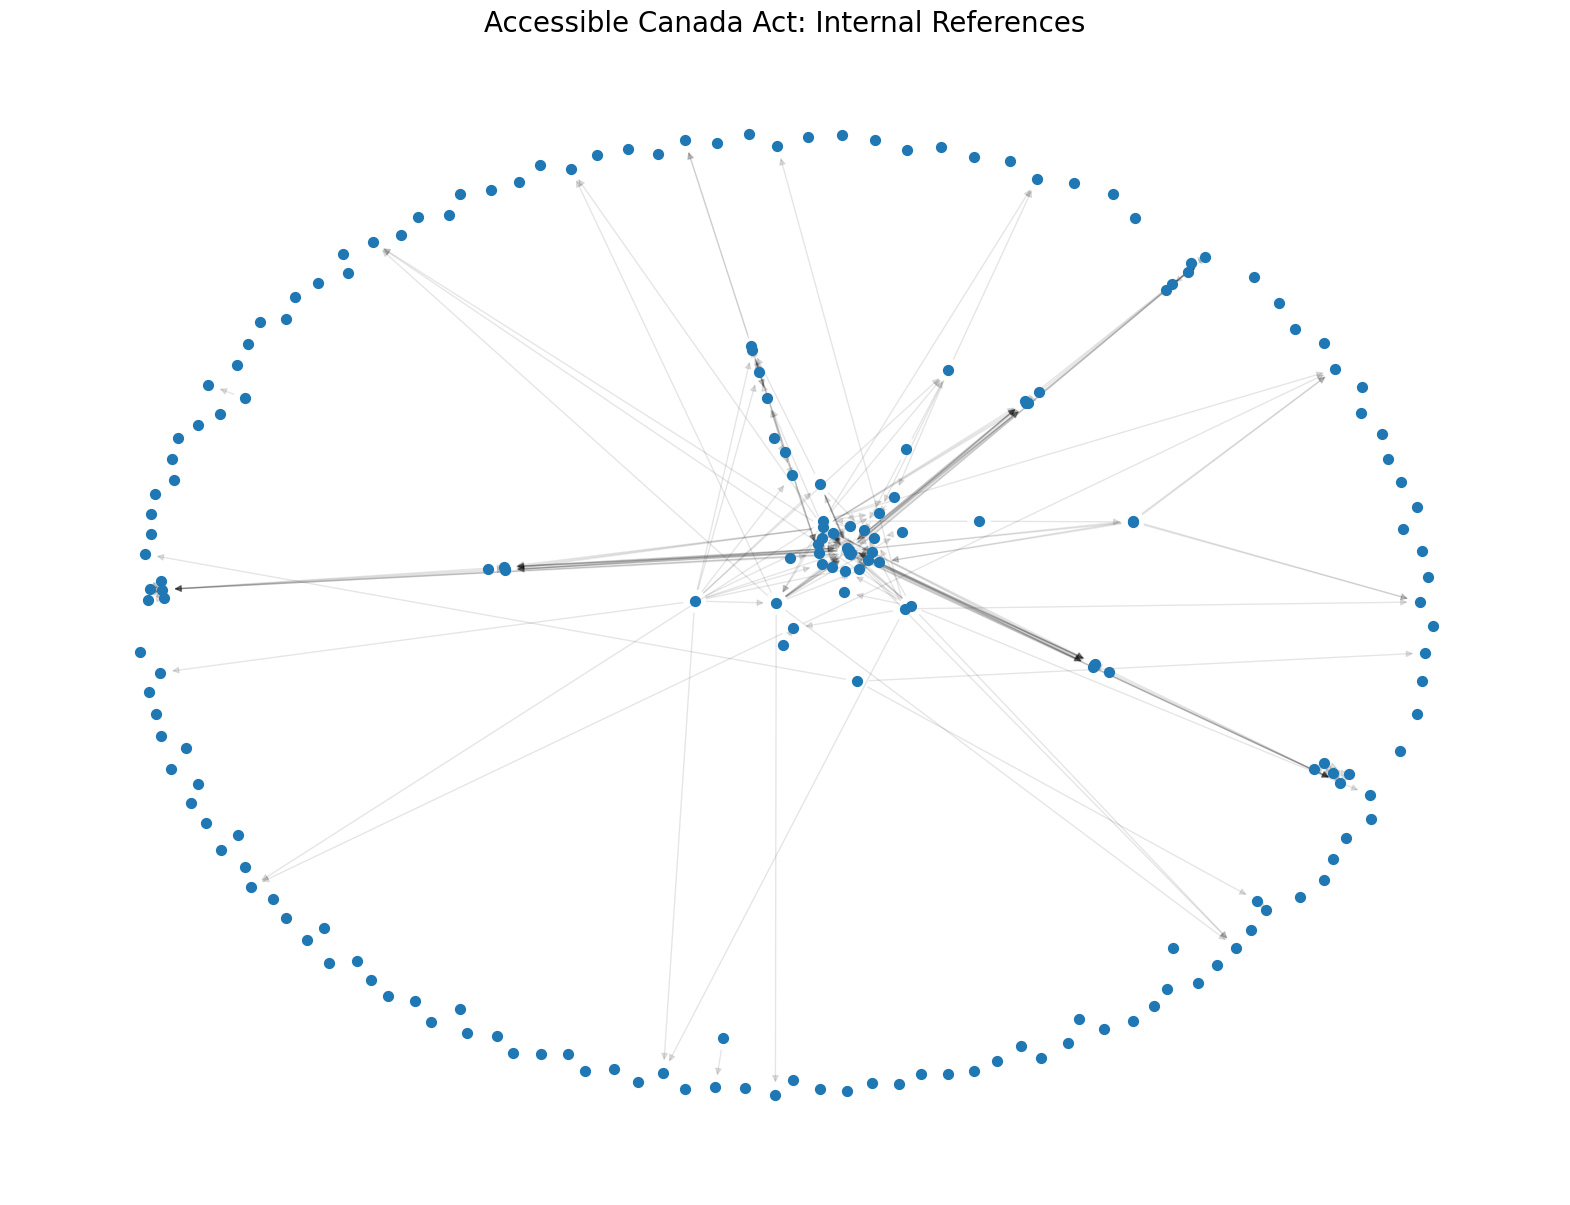

In [138]:
top_in_degree, top_out_degree = plot_internal_references(aca, plot_title="Accessible Canada Act: Internal References")

### Follow links to augment section content

Relationships for section 77:
Inlinks: []
Outlinks: ['91', '47', '48', '49', '56', '57', '58', '65', '66', '67', '69', '70', '71', '73', '124', '126', '74', '75', '76', '117', '125', '140']
Cycles? [('117', '118'), ('118', '117')]


C:\Users\jkuehn\AppData\Local\Temp\ipykernel_21784\2660927413.py:66: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_section, prog="dot")


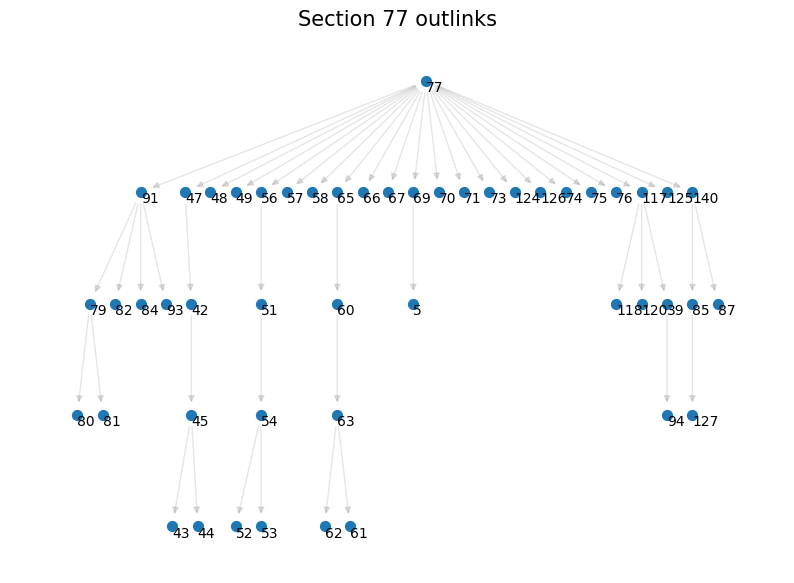

In [139]:
section_id = top_out_degree[0][0]
G_section = plot_internal_reference_tree(aca, section_id)

In [140]:
mega_refs_text = get_section_and_related_text(aca, "77")
print(mega_refs_text)

>>>>>> LEVEL 0

Section 77: 77
(1)
Every regulated entity that contravenes any of the following commits a violation and is liable to a warning or to a penalty fixed in accordance with regulations made under subsection 
91
(a)
any of subsections 
47
48
49
56
57
58
65
66
67
69
70
71
73
124
126
(b)
an order made under section 
74
(c)
an order made under subsection 
75
76
(d)
a provision of regulations made under subsection 
117
(2)
Every person that contravenes an order made under any of paragraphs 
73
73
124
125
91
(3)
Subsection (2) does not apply to a 
specified person
140

>>>>>> LEVEL 1

Section 91: 91
(1)
The Governor in Council may make regulations
(a)
classifying each violation as a minor violation, a serious violation or a very serious violation;
(b)
fixing a penalty, or a range of penalties, in respect of each violation;
(c)
establishing criteria to be considered in determining the amount of the penalty if a range of penalties is established;
(d)
respecting the determination of 

### How much context do you need to answer a question?

GPT-3.5 has a context window of either 4k or 16k tokens.
GPT-4 has 8k, 32k and (as of November 2023) 128k windows.

In [141]:
# Will this fit into the context window of GPT-3.5?
import tiktoken

def num_tokens_from_string(string: str, model: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Using tiktoken, estimate the number of tokens in the document
tokens = num_tokens_from_string(mega_refs_text, "gpt-3.5-turbo")
print(tokens, "tokens")

10941 tokens


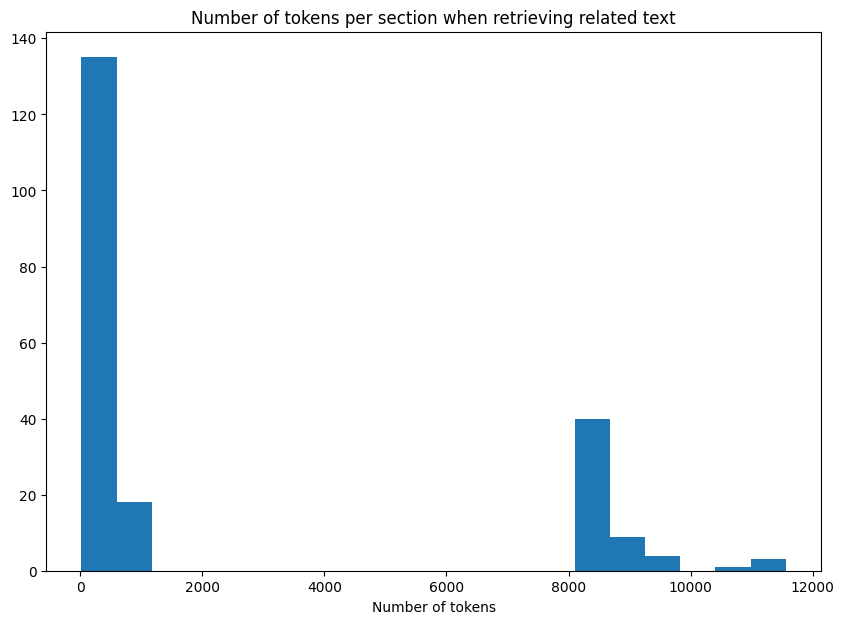

In [142]:
# On average, how many tokens per section after retrieving related text?
tokens_per_section = []
for section in aca["sections"]:
    all_text_including_refs = get_section_and_related_text(aca, section["id"])
    tokens = num_tokens_from_string(all_text_including_refs, "gpt-3.5-turbo")
    tokens_per_section.append(tokens)

# Plot histogram
plt.figure(figsize=(10, 7))
plt.hist(tokens_per_section, bins=20)
plt.title("Number of tokens per section when retrieving related text")
plt.xlabel("Number of tokens")
plt.show()

## External references (between documents)

There are also (numerous) references to other documents, especially from regulations which refer to acts.

In [143]:
def plot_external_references(document, plot_title="External References"):
    # Create a graph of the document where the nodes are the sections and the edges are the internal_refs
    G = nx.DiGraph()
    G.add_nodes_from([x["id"] for x in legislation])
    for d in legislation:
        for ref in d["external_refs"]:
            try:
                G.add_edge(d["id"], ref["link"], weight=ref["count"])
            except:
                continue

    document_inlinks = [n for n in G.predecessors(document["id"])]
    document_outlinks = [n for n in G.neighbors(document["id"])]
    # Filter to only include document itself and its inlinks and outlinks
    G = G.subgraph([document["id"]] + document_inlinks + document_outlinks)

    print(f"Relationships for document {document['id']}:")
    print(f"Inlinks: {document_inlinks}")
    print(f"Outlinks: {document_outlinks}")
    # Are there cycles in the graph?
    try:
        print("Cycles:", nx.find_cycle(G))
    except:
        print("No cycles found")

    plt.figure(figsize=(20, 15))
    pos = nx.spring_layout(G, k=0.5, iterations=30)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=["red" if n == document["id"] else "blue" for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    plt.axis("off")
    plt.title(plot_title, fontsize=20)
    plt.show()


def plot_external_reference_tree(document, plot_title="External References"):
    # Create a graph of the document where the nodes are the sections and the edges are the internal_refs
    G = nx.DiGraph()
    G.add_nodes_from([x["id"] for x in legislation])
    for d in legislation:
        for ref in d["external_refs"]:
            try:
                G.add_edge(d["id"], ref["link"], weight=ref["count"])
            except:
                continue

    # Plot the BFS from this section as a tree
    G_section = nx.bfs_tree(G, source=document["id"])
    # Remove cycles!
    try:
        G_section.remove_edge(document["id"], document["id"])
    except:
        pass
    plt.figure(figsize=(20, 15))
    pos = nx.nx_pydot.graphviz_layout(G_section, prog="dot")
    nx.draw_networkx_nodes(G_section, pos, node_size=50)
    nx.draw_networkx_edges(G_section, pos, alpha=0.1)
    nx.draw_networkx_labels(G_section, pos, font_size=10, font_family="sans-serif", horizontalalignment="left", verticalalignment="top")
    plt.axis("off")
    plt.title(plot_title, fontsize=15)
    plt.show()


Relationships for document A-0.6:
Inlinks: ['A-0.6', 'B-9.01', 'C-10.4', 'C-22', 'C-3.45', 'C-46', 'H-6', 'P-1.3', 'P-33.01', 'P-33.3', 'T-3.4', 'SOR-2006-6', 'SOR-2019-244', 'SOR-2020-105', 'SOR-2021-160', 'SOR-2021-161', 'SOR-2021-241', 'SOR-2021-243', 'DORS-2006-6', 'DORS-2019-244', 'DORS-2020-105', 'DORS-2021-160', 'DORS-2021-161', 'DORS-2021-241', 'DORS-2021-243']
Outlinks: ['P-36', 'P-1.3', 'P-33.35', 'C-10.4', 'B-9.01', 'E-5.401', 'P-33.3', 'S-19', 'A-2', 'A-0.6', 'T-13', 'H-6', 'P-21', 'F-11', 'S-22', 'gazette', 'I-2.5', 'P-32', 'T-3.4', 'R-10', 'C-46', 'G-5', 'P-33.01']
Cycles: [('T-3.4', 'T-3.4')]


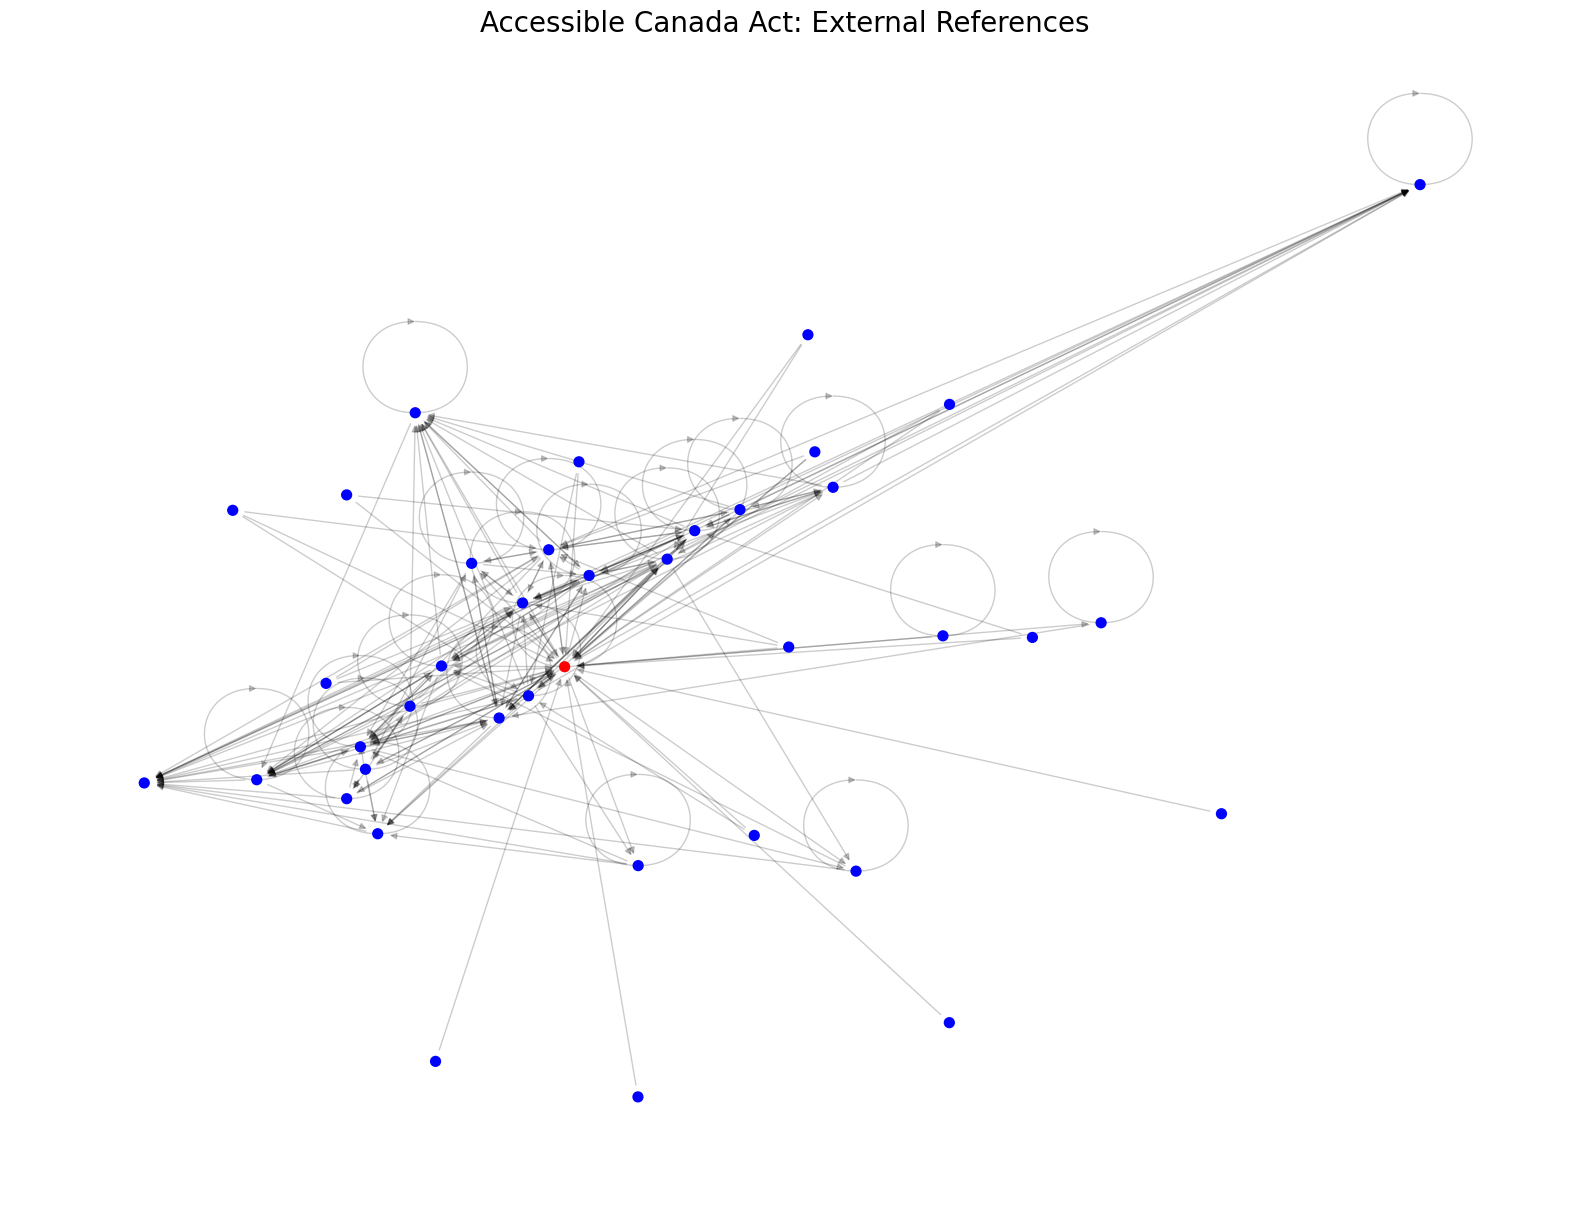

In [144]:
plot_external_references(aca, plot_title="Accessible Canada Act: External References")

C:\Users\jkuehn\AppData\Local\Temp\ipykernel_21784\1237649206.py:55: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G_section, prog="dot")


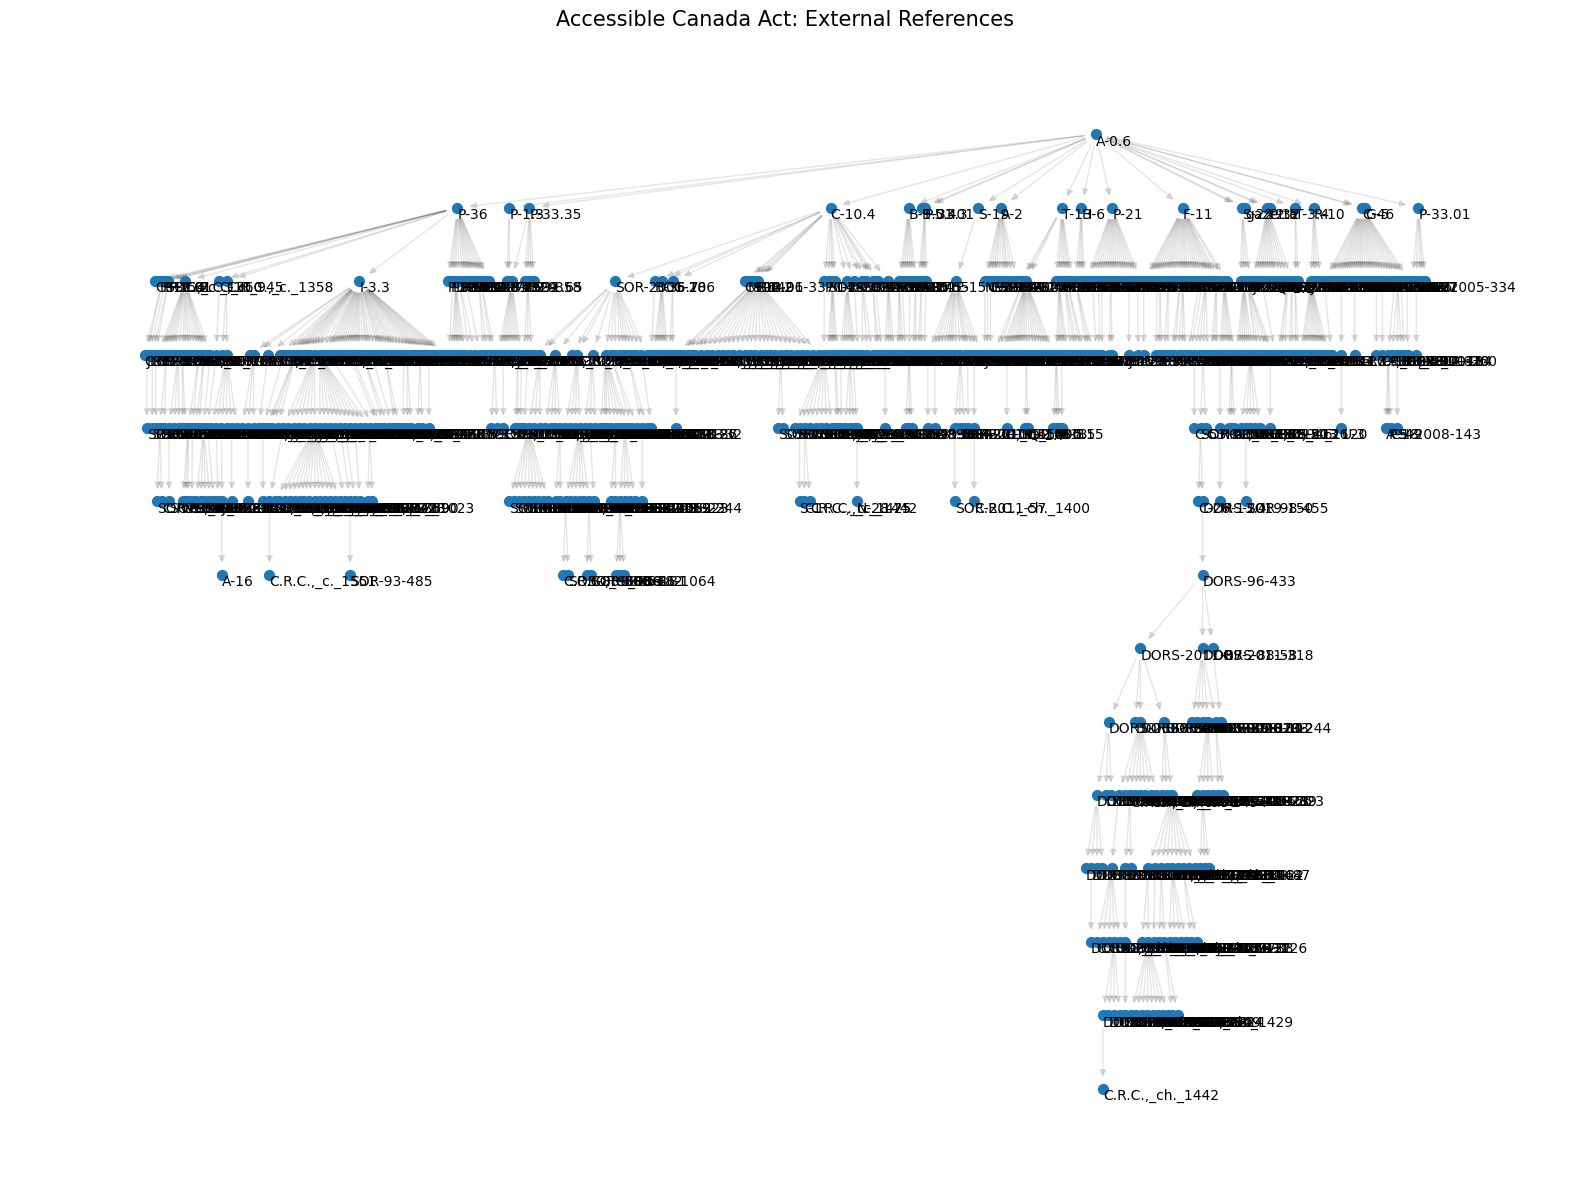

In [145]:
# Clearly, it is totally infeasible to follow all the external references.
plot_external_reference_tree(aca, "Accessible Canada Act: External References")

In [146]:
# Which sections of the ACA have the most external references?
ref_count_by_sections = defaultdict(int)
for section in aca["sections"]:
    for ref in section["external_refs"]:
        if ref["link"] in [d["id"] for d in legislation]:
            ref_count_by_sections[section["id"]] += 1

top_sections = sorted(ref_count_by_sections.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_sections)

[('94', 6), ('2', 5), ('7', 3), ('30', 3), ('60', 3)]


### External references: Strategy

It is not feasible to follow all the external references for a document, but there is likely only a limited number of external references within a particularly relevant section.

Look for external references only within relevant section. These directly referenced documents are Level 1 in the tree.

We would retrieve the relevant sections of the Level 1 documents, then follow any external references from within them (Level 2 documents)

And so on if necessary.

## Text chunking: Number of chunks and sizes

How large are the documents? Sections? Subsections?

In [147]:
doc_stats = []

for document in legislation:
    doc_stats.append({
        "id": document["id"],
        "num_sections": len(document["sections"]),
        "num_subsections": sum(len(section["subsections"]) for section in document["sections"]),
        "text_len": len(document["full_text"]),
        "section_lens": [len(section["text"]) for section in document["sections"]],
        "subsection_lens": [len(subsection["text"]) for section in document["sections"] for subsection in section["subsections"]],
    })

print(doc_stats[0])

{'id': 'A-0.6', 'num_sections': 210, 'num_subsections': 358, 'text_len': 154669, 'section_lens': [1042, 53, 576, 56, 145, 745, 427, 273, 1203, 1460, 227, 243, 190, 412, 267, 144, 150, 33, 193, 318, 740, 1192, 229, 183, 139, 1207, 268, 120, 300, 201, 100, 548, 741, 504, 312, 174, 147, 59, 352, 165, 320, 1003, 1159, 343, 2473, 533, 963, 939, 279, 1653, 548, 934, 343, 2164, 533, 963, 938, 278, 1630, 548, 934, 343, 2128, 504, 934, 965, 299, 1923, 548, 934, 343, 1544, 594, 980, 343, 3402, 480, 284, 607, 551, 85, 887, 544, 1334, 2663, 824, 1640, 515, 530, 315, 161, 256, 158, 909, 186, 292, 850, 788, 460, 194, 990, 111, 749, 512, 2640, 968, 403, 531, 1257, 138, 269, 91, 87, 781, 495, 194, 350, 397, 484, 2607, 406, 141, 615, 742, 167, 2021, 353, 214, 264, 276, 55, 1101, 278, 49, 495, 353, 127, 540, 111, 121, 489, 796, 39, 3697, 393, 1266, 985, 768, 461, 193, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1

In [158]:
len(legislation)

10199

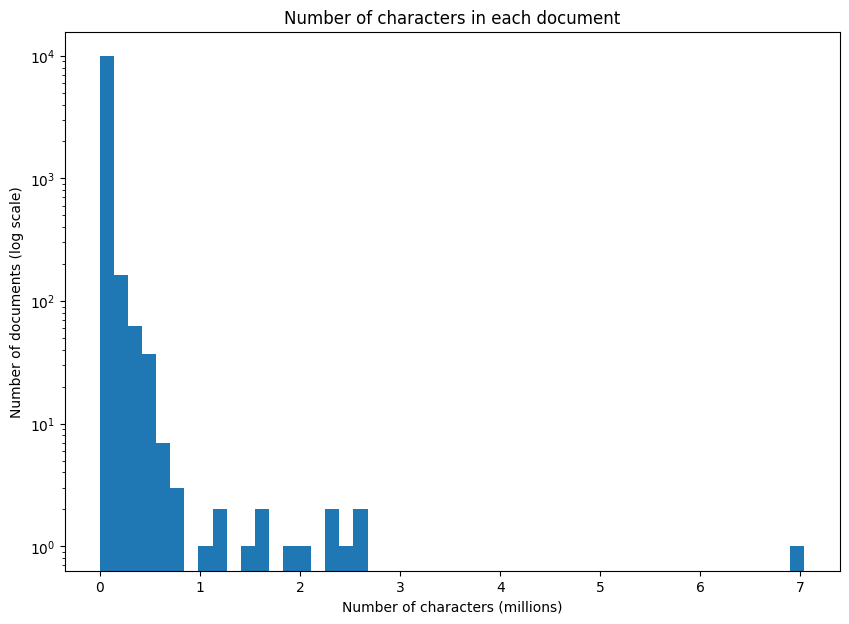

In [163]:
# How many characters of text are in each document?
# We have to make this log scale because of the income tax act...
plt.figure(figsize=(10, 7))
plt.hist([d["text_len"]/1000000 for d in doc_stats], bins=50)
plt.title("Number of characters in each document")
plt.xlabel("Number of characters (millions)")
plt.ylabel("Number of documents (log scale)")
plt.yscale("log")
plt.show()

In [160]:
# What are the longest documents?
def get_legislation_by_id(document_id):
    return [d for d in legislation if d["id"] == document_id][0]

[(t["id"], get_legislation_by_id(t["id"])["short_title"], t["text_len"]) for t in sorted(doc_stats, key=lambda x: x["text_len"], reverse=True)[:5]]

[('I-3.3', 'Income Tax Act', 7039285),
 ('C.R.C.,_ch._945', 'Règlement de l’impôt sur le revenu', 2671271),
 ('E-15', 'Excise Tax Act', 2589970),
 ('C.R.C.,_c._945', 'Income Tax Regulations', 2505805),
 ('C-46', 'Criminal Code', 2377149)]

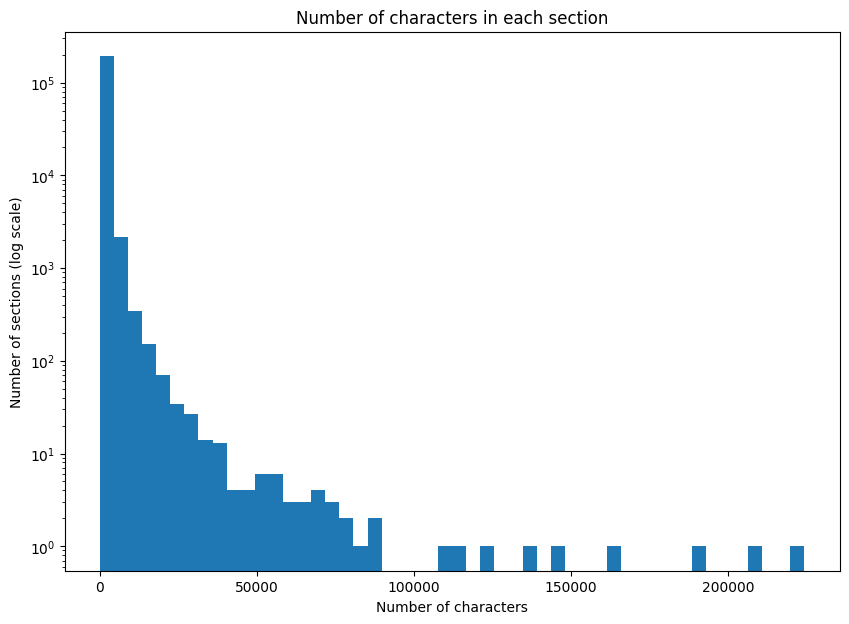

In [164]:
# How many characters of text are in each section?
plt.figure(figsize=(10, 7))
plt.hist([x for d in doc_stats for x in d["section_lens"]], bins=50)
plt.title("Number of characters in each section")
plt.xlabel("Number of characters")
plt.ylabel("Number of sections (log scale)")
plt.yscale("log")
plt.show()

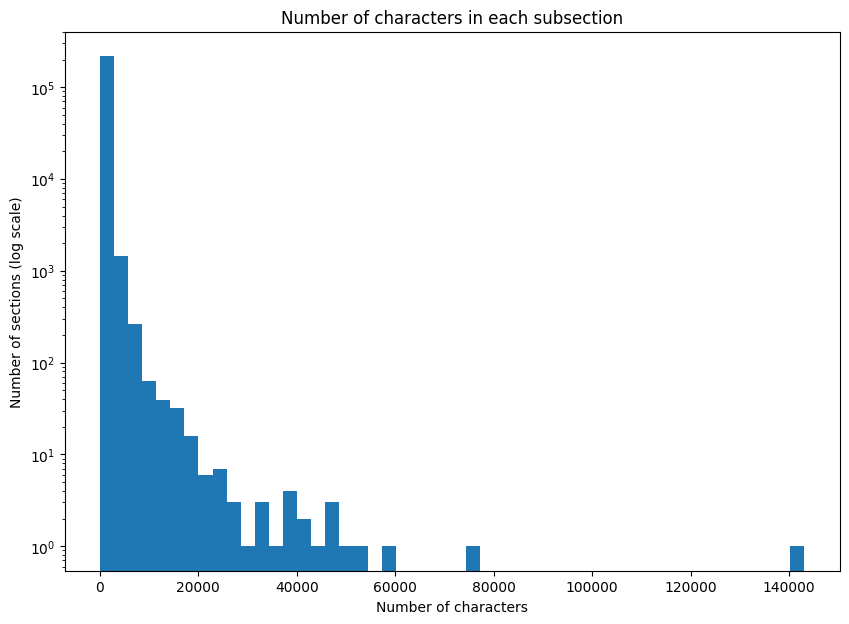

In [165]:
# How many characters of text are in each SUBsection?
plt.figure(figsize=(10, 7))
plt.hist([x for d in doc_stats for x in d["subsection_lens"]], bins=50)
plt.title("Number of characters in each subsection")
plt.xlabel("Number of characters")
plt.ylabel("Number of sections (log scale)")
plt.yscale("log")
plt.show()

In [169]:
# What document contains the longest subsection?
[
    (t["id"], get_legislation_by_id(t["id"])["short_title"], max(t["subsection_lens"]))
    for t in sorted(
        [d for d in doc_stats if d["subsection_lens"]],
        key=lambda x: max(x["subsection_lens"]),
        reverse=True,
    )[:5]
]

[('I-3.3', 'Income Tax Act', 143126),
 ('E-15', 'Excise Tax Act', 57799),
 ('DORS-2007-303', None, 52655),
 ('C.R.C.,_ch._945', 'Règlement de l’impôt sur le revenu', 51214),
 ('C.R.C.,_c._945', 'Income Tax Regulations', 47428)]

In [186]:
def get_longest_section(document_id):
    document = get_legislation_by_id(document_id)
    sections = [(section["text"], len(section["text"]), section["id"]) for section in document["sections"]]
    return sorted(sections, key=lambda x: x[1], reverse=True)[0]

def get_longest_subsection(document_id):
    document = get_legislation_by_id(document_id)
    subsections = [(subsection["text"], len(subsection["text"])) for section in document["sections"] for subsection in section["subsections"]]
    return sorted(subsections, key=lambda x: x[1], reverse=True)[0]

longest_subsection = get_longest_subsection("I-3.3")[0]
print(longest_subsection)

(1)
In this Act,
active business
entreprise exploitée activement
additional voluntary contribution
cotisation facultative
adjusted cost base
prix de base rajusté
adjustment time
[Repealed, 2016, c. 12, s. 63]
advanced life deferred annuity
rente viagère différée à un âge avancé
aggregate investment income
revenu de placement total
allowable business investment loss
perte déductible au titre d’un placement d’entreprise
allowable capital loss
perte en capital déductible
alter ego trust
fiducie en faveur de soi-même
amateur athlete trust
fiducie au profit d’un athlète amateur
amortized cost
(a)
in the case of a loan made by the taxpayer, the total of all amounts advanced in respect of the loan at or before that time,
(b)
in the case of a loan or lending asset acquired by the taxpayer, the cost of the loan or lending asset to the taxpayer,
(c)
in the case of a loan or lending asset acquired by the taxpayer, the part of the amount, if any, by which
(i)
the principal amount of the loan or le

In [187]:
# How many tokens?
tokens = num_tokens_from_string(longest_subsection, "gpt-3.5-turbo")
print(tokens, "tokens in longest Subsection of the Income Tax Act")

tokens = num_tokens_from_string(get_longest_section("I-3.3")[0], "gpt-3.5-turbo")
print(tokens, "tokens in longest Section of the Income Tax Act")

31495 tokens in longest Subsection of the Income Tax Act
41860 tokens in longest Section of the Income Tax Act
